Original Data Description:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000  

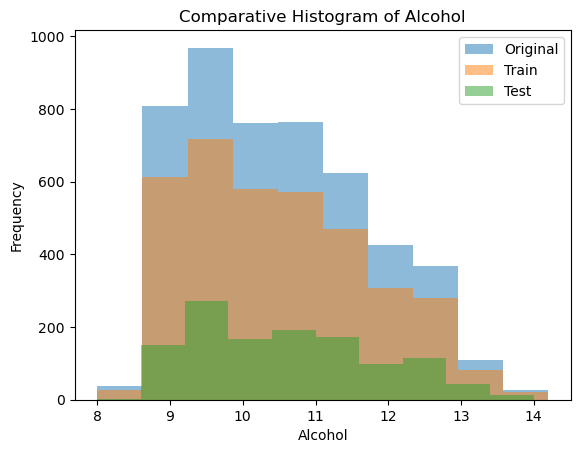

In [1]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Carregar a Planilha
df = pd.read_csv("winequality-white.csv", sep=";")
original_df = df.copy()

# 2. Tratamento de Dados
df.drop(columns=['quality'], inplace=True)

# 3. Dividir Dados
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

# 4. Estatística Descritiva
print("Original Data Description:\n", original_df.describe())
print("\nTraining Data Description:\n", train_df.describe())
print("\nTest Data Description:\n", test_df.describe())

# 5. Histograma Comparativo
plt.hist(original_df['alcohol'], alpha=0.5, label='Original')
plt.hist(train_df['alcohol'], alpha=0.5, label='Train')
plt.hist(test_df['alcohol'], alpha=0.5, label='Test')
plt.xlabel('Alcohol')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Comparative Histogram of Alcohol')
plt.show()

# 6. Normalização
def standard_scaler(df):
    return (df - df.mean()) / df.std()

train_df_scaled = standard_scaler(train_df)
test_df_scaled = standard_scaler(test_df)

In [2]:
# 7. KFold Manual
def manual_kfold(df, k=5):
    folds = []
    fold_size = len(df) // k
    for i in range(k):
        test = df.iloc[i*fold_size:(i+1)*fold_size]
        train = df.drop(test.index)
        folds.append((train, test))
    return folds

# 8. Regressão Linear OLS Manual
def ols(X, y):
    X = np.c_[np.ones(X.shape[0]), X]  # Adicionando uma coluna de uns para o intercepto
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

# 9. Avaliação do Modelo
def model_evaluation(X, y, beta):
    y_pred = X @ beta
    residuals = y - y_pred
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    ssr = sum(residuals**2)
    sst = sum((y - np.mean(y))**2)
    r2 = 1 - (ssr / sst)
    return rmse, r2, y_pred, residuals


Mean RMSE for 5 -Folds: 0.3765710933460136
Mean R2 for 5 -Folds: 0.8462411352664025
Mean RMSE for 10 -Folds: 0.3650579223413354
Mean R2 for 10 -Folds: 0.8439315072937467


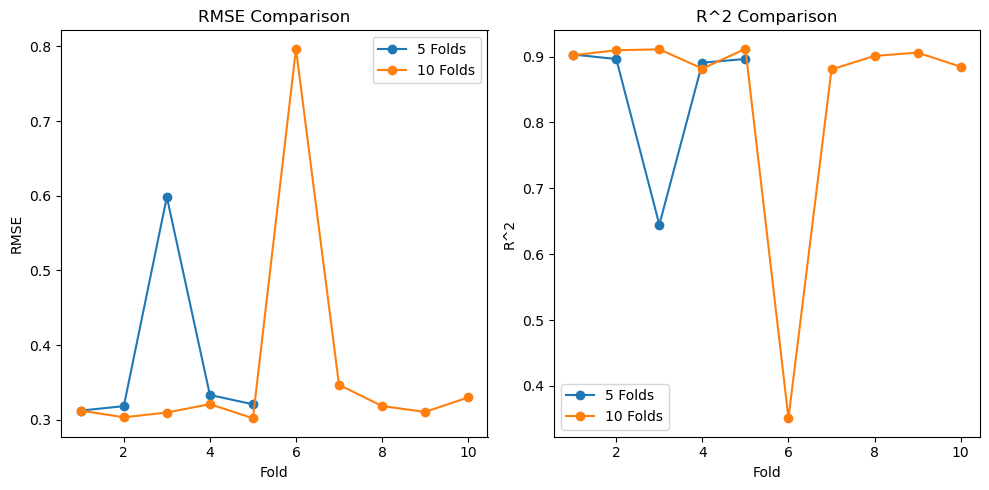

In [3]:
import matplotlib.pyplot as plt

# Função para calcular as métricas e retornar os valores
def calculate_metrics(folds):
    all_y_test = []
    all_y_pred = []
    rmse_values = []
    r2_values = []
    for fold in folds:
        train, test = fold
        X_train, y_train = train.drop(columns=['alcohol']), train['alcohol']
        X_test, y_test = test.drop(columns=['alcohol']), test['alcohol']
        
        beta = ols(X_train, y_train)
        rmse, r2, y_pred, residuals = model_evaluation(np.c_[np.ones(X_test.shape[0]), X_test], y_test, beta)
        
        rmse_values.append(rmse)
        r2_values.append(r2)
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
        
    return rmse_values, r2_values, all_y_test, all_y_pred, X_train, X_test, beta, y_test


# Executar a função com 5 e 10 folds
folds_5 = manual_kfold(train_df_scaled, k=5)
folds_10 = manual_kfold(train_df_scaled, k=10)

# Chamando a função e desempacotando todos os quatro valores retornados
rmse_5, r2_5, all_y_test_5, all_y_pred_5, X_train, X_test, beta, y_test = calculate_metrics(folds_5)
mean_rmse_5 = sum(rmse_5) / len(rmse_5)
mean_r2_5 = sum(r2_5) / len(r2_5)
print(f'Mean RMSE for 5 -Folds: {mean_rmse_5}')
print(f'Mean R2 for 5 -Folds: {mean_r2_5}')
rmse_10, r2_10, all_y_test_10, all_y_pred_10, X_train, X_test, beta, y_test = calculate_metrics(folds_10)
mean_rmse_10 = sum(rmse_10) / len(rmse_10)
mean_r2_10 = sum(r2_10) / len(r2_10)
print(f'Mean RMSE for 10 -Folds: {mean_rmse_10}')
print(f'Mean R2 for 10 -Folds: {mean_r2_10}')

# Plotar os resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 6), rmse_5, marker='o', label='5 Folds')
plt.plot(range(1, 11), rmse_10, marker='o', label='10 Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), r2_5, marker='o', label='5 Folds')
plt.plot(range(1, 11), r2_10, marker='o', label='10 Folds')
plt.xlabel('Fold')
plt.ylabel('R^2')
plt.title('R^2 Comparison')
plt.legend()

plt.tight_layout()
plt.show()

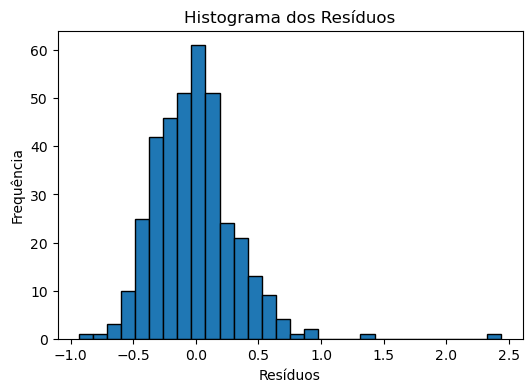

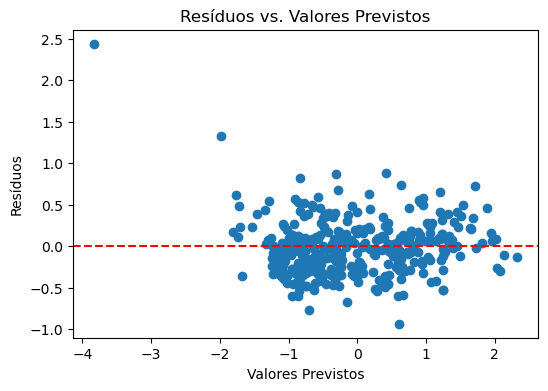

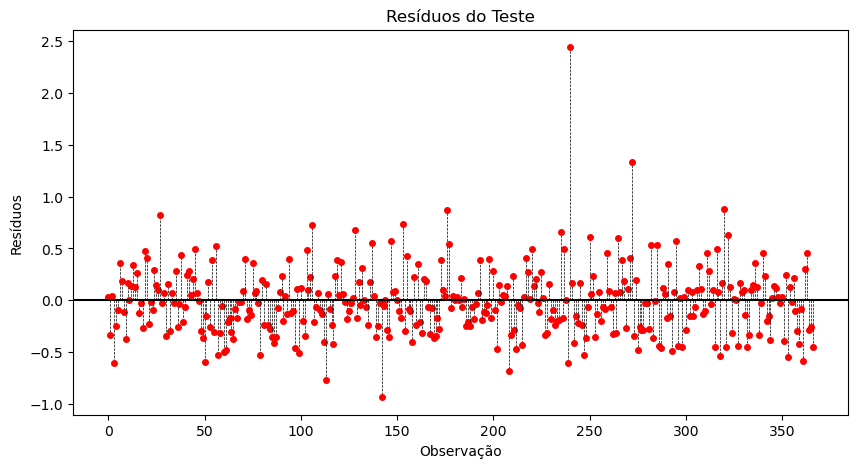

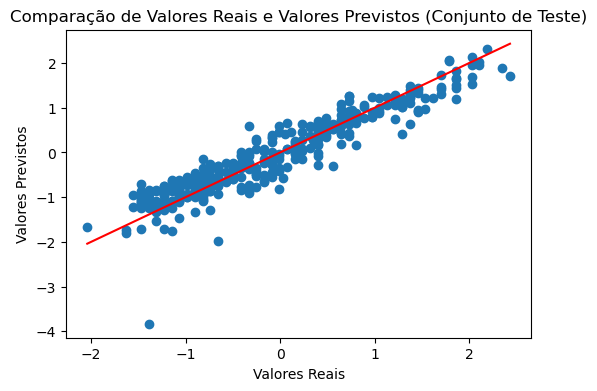

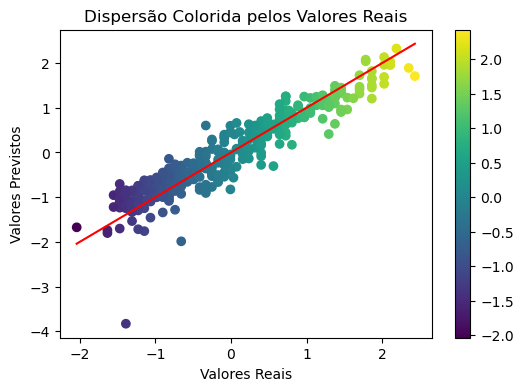

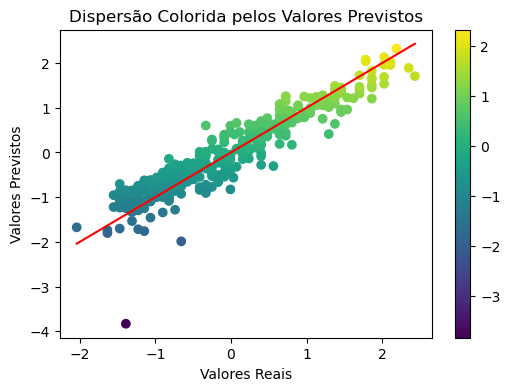

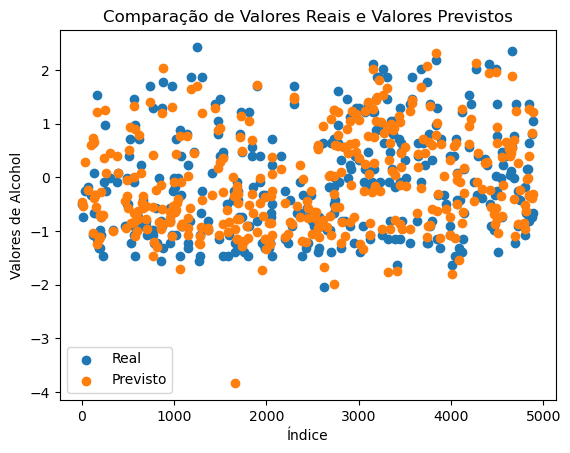

Test RMSE: 0.3298756317286459
Test R2: 0.8845971605640548


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Adicionando uma coluna de 1s ao X_test para o intercepto
X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test] 

# Calculando os valores previstos
y_pred = X_test_with_intercept @ beta

# Calculando os resíduos
residuals = y_test - y_pred

# Histograma dos Resíduos
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()

# Resíduos vs. Valores Previstos
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs. Valores Previstos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.show()

# Criando o gráfico
fig, ax = plt.subplots(figsize=(10, 5))
# Plotando os resíduos do teste, conectando cada ponto à linha y=0
for i, residuals in enumerate(residuals):
    ax.plot([i, i], [0, residuals], color='black', linestyle='--', linewidth=0.5)
    ax.plot(i, residuals, marker='o', markersize=4, color='red')

# Adicionando uma linha horizontal y=0 para referência
ax.axhline(y=0, color='black', linestyle='-')
# Configurando labels
ax.set_xlabel('Observação')
ax.set_ylabel('Resíduos')
ax.set_title('Resíduos do Teste')
plt.show()

# Plotar os resíduos do teste no segundo subplot
ax.plot(residuals, marker='o', markersize=4, linestyle='--', color='black', markerfacecolor='red', linewidth=0.3, markeredgewidth=0)
ax.axhline(y=0, color='black', linestyle='-')
ax.set_xlabel('Observação')
ax.set_ylabel('Resíduos')
#ax.set_title('Resíduos do Teste')
plt.show()

# Comparação de Valores Reais e Valores Previstos (Conjunto de Teste)
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # linha y=x
plt.title('Comparação de Valores Reais e Valores Previstos (Conjunto de Teste)')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()

# Comparação de Valores Reais e Valores Previstos (Conjunto de Teste) - Dispersão Colorida pelos Valores Reais
plt.figure(figsize=(6, 4))
scatter = plt.scatter(y_test, y_pred, c=y_test, cmap='viridis')
plt.colorbar(scatter)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # linha y=x
plt.title('Dispersão Colorida pelos Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()

# Comparação de Valores Reais e Valores Previstos (Conjunto de Teste) - Dispersão Colorida pelos Valores Previstos
plt.figure(figsize=(6, 4))
scatter = plt.scatter(y_test, y_pred, c=y_pred, cmap='viridis')
plt.colorbar(scatter)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # linha y=x
plt.title('Dispersão Colorida pelos Valores Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()

# 3. Comparação de Valores Reais e Valores Previstos
plt.scatter(y_test.index, y_test, label='Real')
plt.scatter(y_test.index, y_pred, label='Previsto')
plt.legend()
plt.title('Comparação de Valores Reais e Valores Previstos')
plt.xlabel('Índice')
plt.ylabel('Valores de Alcohol')
plt.show()

# Calcular e imprimir métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')
